<a href="https://colab.research.google.com/github/jdblackiii/jdastro/blob/main/JD_GravitationalWave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp310-cp310-linux_x86_64.whl size=99254 sha256=2d73bb02b66fe2d1f4e17ae6961f6d101038ee51ba71153d01b18cf2095eee36
  Stored in directory: /root/.cache/pip/wheels/6d/48/d1/3466977be4e41ba57f92ad0d5619f083df43cf319a151c4e06
Successfully built ligo-segments


The following example is from: https://gwpy.github.io/docs/stable/examples/signal/gw150914/

In [2]:
# # -- Set a GPS time:
# t0 = 1126259462.4    # -- GW150914
# t0 = 1187008882.4    # -- GW170817
t0 = 1242459857.4 # GW190521_074359

from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', t0 - 16.0, t0 + 16.0)

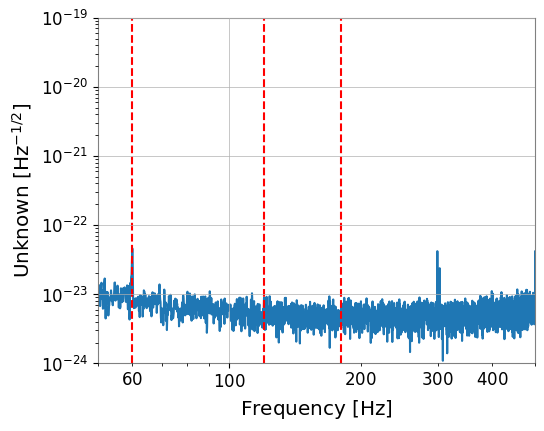

In [3]:
import matplotlib.pyplot as plt

# Plot fourier transform of data -- se constituent frequencies
fig2 = hdata.asd(fftlength=8).plot()
plt.xlim(50,500)
ymin = 1e-24
ymax = 1e-19
plt.ylim(ymin, ymax)
plt.vlines(60, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(120, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(180, ymin, ymax, linestyle="dashed", color="red")

In [4]:
from gwpy.signal import filter_design

# Create bandpass filter from 50Hz to 250Hz
bp = filter_design.bandpass(50, 250, hdata.sample_rate)

# Add notches to filter
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)]

zpk = filter_design.concatenate_zpks(bp, *notches)

hfilt = hdata.filter(zpk, filtfilt=True)


In [5]:
# Crop data
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))

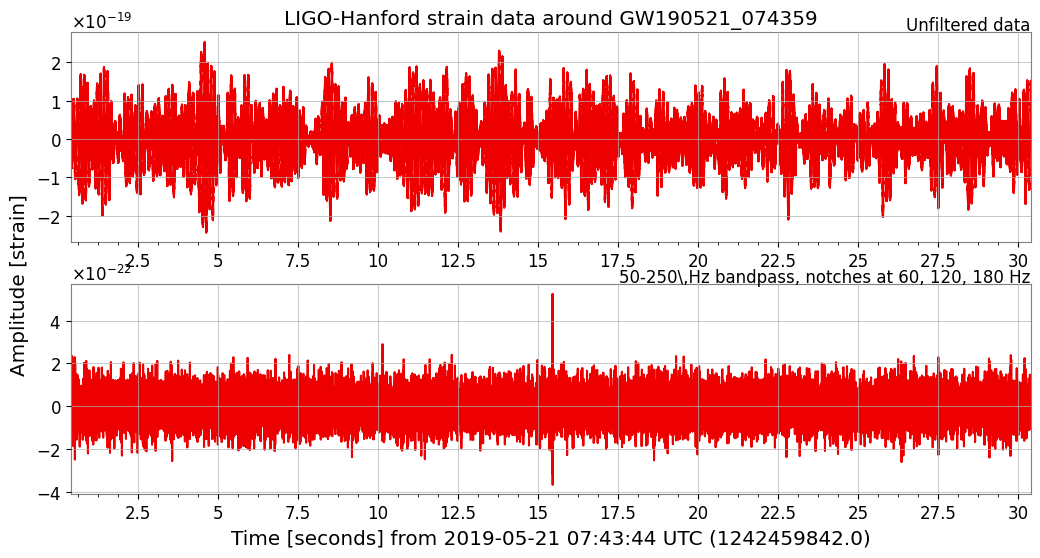

In [6]:
from gwpy.plot import Plot

# Create plot comparing filtered and unfiltered Hanford Data
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW190521_074359')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

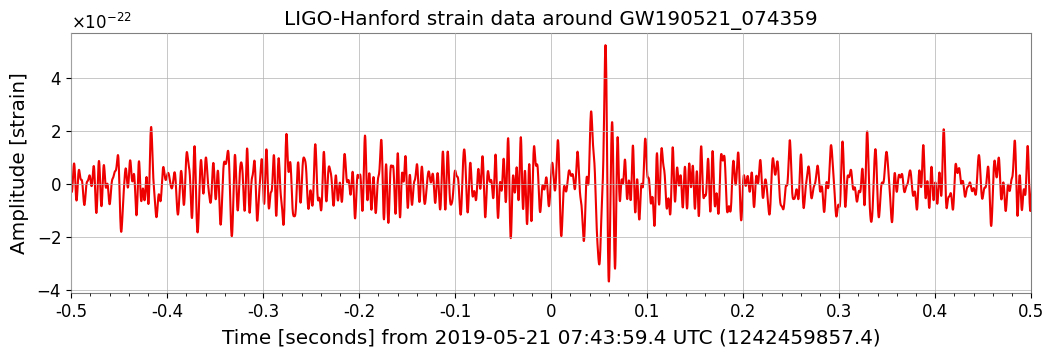

In [7]:
import matplotlib.pyplot as plt

# Create plot for strain data at Hartford
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW190521_074359')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(t0 - 0.5, t0 + 0.5)
ax.set_xscale('seconds', epoch=t0)
plot.show()

x_val = plt.gca().lines[0].get_xdata()
y_val = plt.gca().lines[0].get_ydata()


In [8]:
ldata = TimeSeries.fetch_open_data('L1', t0 - 16, t0 + 16)
lfilt = ldata.filter(zpk, filtfilt=True)

In [9]:
lfilt.shift('6.9ms')
lfilt *= -1

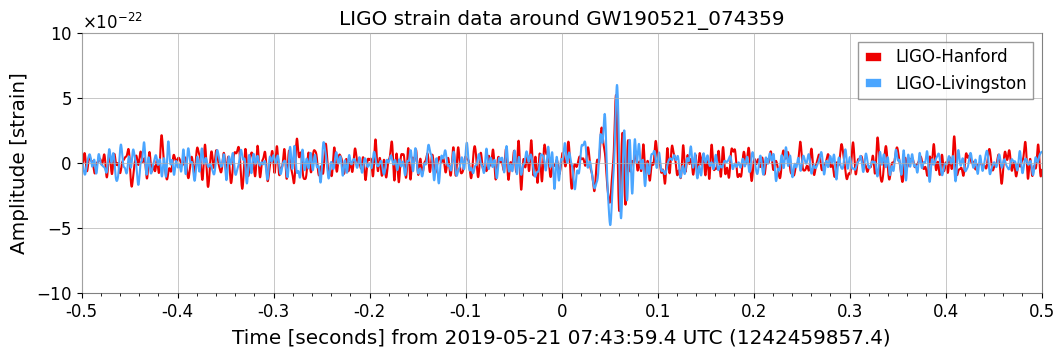

In [10]:
# Create plot comparing Hartford and Livingston results
plot = Plot(figsize=[12, 4])
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data around GW190521_074359')
ax.set_xlim(t0 - 0.5, t0 + 0.5)
ax.set_xscale('seconds', epoch=t0)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()

https://colab.research.google.com/github/losc-tutorial/quickview/blob/master/index.ipynb
Also from: https://gwpy.github.io/docs/stable/examples/signal/qscan/

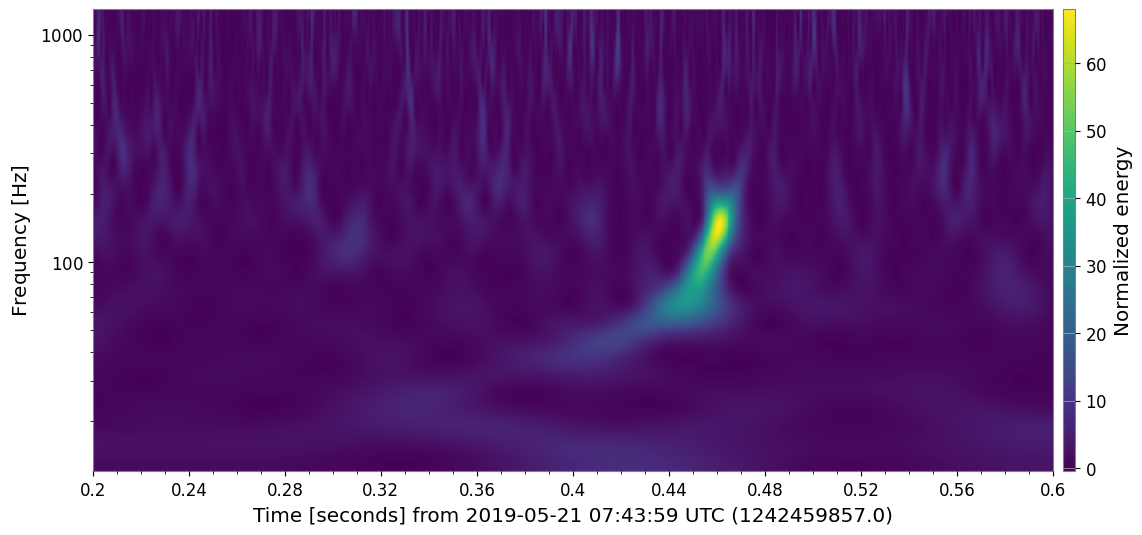

In [11]:
# Create power spectrum plot
dt = 0.2
hq = hfilt.q_transform(outseg=(t0-dt, t0+dt))
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label="Normalized energy")
ax.grid(False)
ax.set_yscale('log')

In [12]:
from scipy.io.wavfile import write
import numpy as np

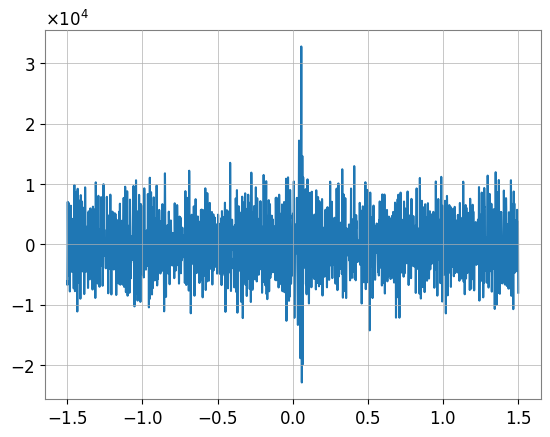

In [13]:
amplitude = np.iinfo(np.int16).max
# Create audio file of event
# Pulls data from within t0 +- 1.5 seconds
ind = np.where((x_val < (t0+1.5)) & (x_val > (t0-1.5)))
y = y_val[ind]

# normalize audio
y = y / np.max(y)

# Multiply each amplitude by the max size of an integer to amplify
# This doesn't overflow because the values are all very very small
plt.plot(x_val[ind] - t0, (np.array(y) * amplitude).astype(np.int16))

In [14]:
# Calculate sampling rate
fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))
print("fs = ", fs)


write("result.wav", fs, (np.array(y) * amplitude).astype(np.int16))

fs =  4096


In [15]:
from google.colab import files
files.download("result.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.5
fs =  4096


<ipython-input-16-b58a7adcc9ee>:54: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label="before frequency multiplication")
<ipython-input-16-b58a7adcc9ee>:61: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label="after frequency multiplication")
<ipython-input-16-b58a7adcc9ee>:69: ComplexWarning: Casting complex values to real discards the imaginary part
  write("example.wav", fs, (np.array(y[0:int(num/up_sample)]) * amplitude).astype(np.int16))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

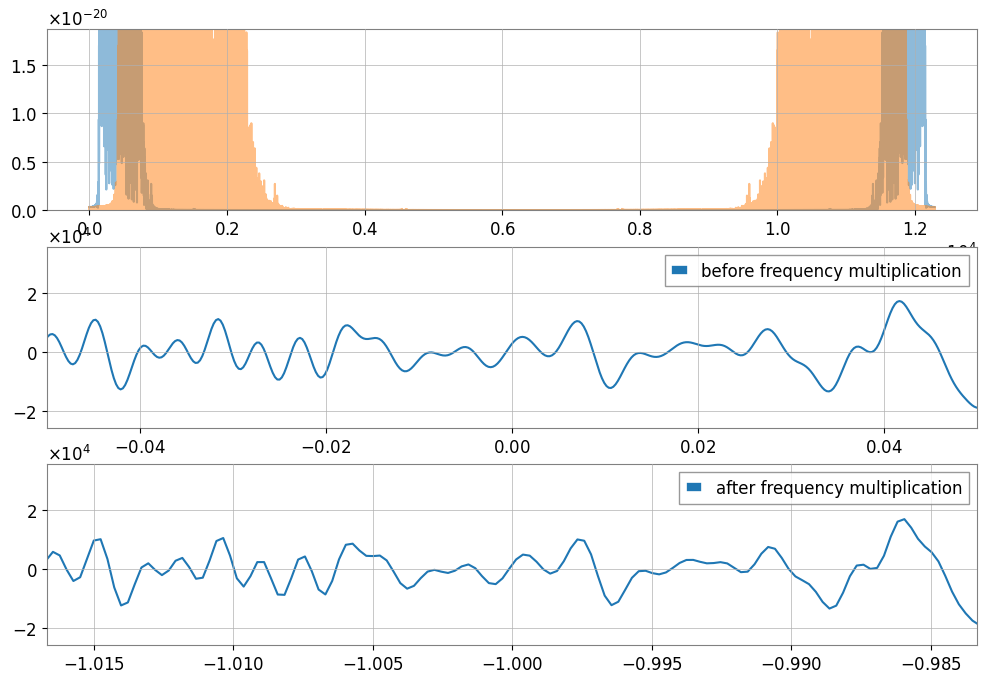

In [16]:
# Amount of the crop
t_clip = 1.5

# Max value of a 16bit int
amplitude = np.iinfo(np.int16).max

# Perform crop
ind = np.where((x_val < (t0+t_clip)) & (x_val > (t0-t_clip)))
x = x_val[ind]
y = y_val[ind]

# plt.plot(x - t0, (np.array(y / np.max(y)) * amplitude) + 10000, label="oringinal")
# print(np.min(np.array(y / np.max(y)) * amplitude), np.max(np.array(y / np.max(y)) * amplitude))

# Amount to upsample the sound by- eg '3' means 3x higher
up_sample = 3

# Perform Fourier transform to extract constituent freq
y_fft = np.fft.fft(y)

# Copy fourier transform to new ndarr
# WARNING: Dangerous aliasing here
y_fft_new = np.zeros(np.shape(y_fft), dtype=np.cdouble)
y_fft_old = y_fft

# Iterate through only portion of ndarr to avoid indexing out of array
# Since we're condensing the sound by a factor of 3, we only want to iterate
# through the first third
num = len(y_fft)
for i in np.arange(int(num / up_sample)):
    y_fft_new[int(i * up_sample)] = y_fft[int(i)]

# Get fourier transform of pre-pitched-up sound
y_old = np.fft.ifft(y_fft_old)

# Ensure symmetry of imaginary component of data
# Without this step, the inverse fourier transform would result in a
# partially imaginary result
for i in np.arange(num):
  if i > (num / 2):
    y_fft_new[i] = np.conjugate(y_fft_new[int(num) - i])

# y_fft_new = np.fft.fftshift(y_fft_new)
y = np.fft.ifft(y_fft_new)

# Plot results
plt.figure(figsize=(12,8))
plt.subplot(311)
plt.plot(np.abs(y_fft_old), alpha=0.5)
plt.plot(np.abs(y_fft_new), alpha=0.5)
ylim = np.percentile(np.abs(y_fft), 95)
plt.ylim(0, ylim)

plt.subplot(312)
# y_old = y_old**3 # to make the signal more distinct from the noise
y_old = y_old / np.max(y_old)
plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label="before frequency multiplication")
plt.xlim(-0.05, 0.05)
plt.legend()

plt.subplot(313)
# y = y**3 # to make the signal more distinct from the noise
y = y / np.max(y)
plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label="after frequency multiplication")
plt.xlim(-t_clip + t_clip / up_sample - 0.05 / up_sample, -t_clip + t_clip / up_sample + 0.05 / up_sample)
plt.legend()
print(t_clip / up_sample)

fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))
# fs = fs * 4 # to make the signal higher pitch
print("fs = ", fs)
write("example.wav", fs, (np.array(y[0:int(num/up_sample)]) * amplitude).astype(np.int16))

from google.colab import files
files.download("example.wav")

In [17]:
!pip install pydub
from pydub import AudioSegment

In [18]:
sound = AudioSegment.from_file("example.wav")
print(sound.frame_rate)
# sound.frame_rate = 1024
print(sound.frame_rate)
sound = sound.set_frame_rate(4096 * 4)
sound.frame_rate = 4096 * 2
sound.export("example_slow.wav")
files.download("example_slow.wav")

4096
4096


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>